In [106]:
#opencv import
import cv2
import numpy as np
import time
import os
import sys
import math
import random
import matplotlib.pyplot as plt
import scipy.signal


In [107]:
nopol = cv2.imread('rubix/nopol.jpg')
nopol = cv2.cvtColor(nopol, cv2.COLOR_BGR2GRAY)

Going to start with an initial algorith to identify a and b from I = aI + bI from two known values of an image. start in greyscale for simplicity

In [108]:
# a = 0.3 b = 0.7 will start with this to initialise
im_0deg = nopol*0.3
im_90deg = nopol*0.7

In [109]:
print(im_0deg[0,0])
print(im_90deg[0,0])
print(nopol[0,0])

75.0
175.0
250


We know that 75+175=250

In [110]:
a = nopol[0,0]/im_0deg[0,0]
b = nopol[0,0]/im_90deg[0,0]

Now we dont know exactly what the point is. Can take both images and apply contrast adjustment to expand them from 0-255 now we will have a point where it is 255 and can work from there

In [111]:
nopol_col = cv2.imread('rubix/nopol.jpg')
nopol_col = cv2.cvtColor(nopol_col, cv2.COLOR_BGR2RGB)

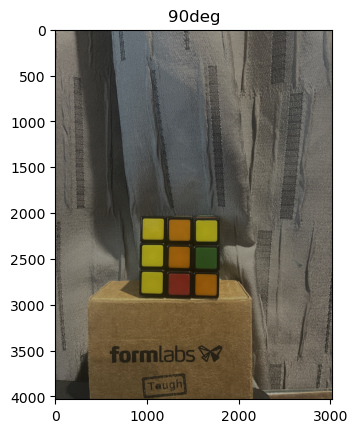

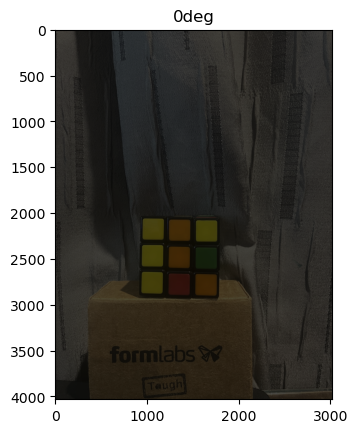

In [112]:
block_90 = nopol_col*0.7
#round all values in block90 to integer
block_90 = np.round(block_90).astype(np.uint8)
# constrast enhancement accross all rgb values
plt.figure()
plt.imshow(block_90)
plt.title('90deg')
plt.show()

block_0 = nopol_col*0.3
#round all values in block90 to integer
block_0 = np.round(block_0).astype(np.uint8)
# constrast enhancement accross all rgb values
plt.figure()
plt.imshow(block_0)
plt.title('0deg')
plt.show()

In [113]:
r_est = int(block_0[0,0,0] + block_90[0,0,0])
g_est = int(block_0[0,0,1] + block_90[0,0,1])
b_est = int(block_0[0,0,2] + block_90[0,0,2])

r_0_est = block_0[0,0,0]/r_est
g_0_est = block_0[0,0,1]/g_est
b_0_est = block_0[0,0,2]/b_est

r_90_est = block_90[0,0,0]/r_est
g_90_est = block_90[0,0,1]/g_est
b_90_est = block_90[0,0,2]/b_est

a_est = sum([r_0_est, g_0_est, b_0_est])/3
b_est = sum([r_90_est, g_90_est, b_90_est])/3

print(f"a_est: {a_est} b_est: {b_est}")

a_est: 0.2994526325234987 b_est: 0.7005473674765014


This wont work all the time as normally the images will be shifted by some amount on each side and this amount is unknown. So we take away 100 pixels from the left of the 0deg pic and 100 pixels from the right of 90deg image however this 100 pixel value could be any

In [114]:
nopol_shifted_left = nopol_col[:,100:,:]
nopol_shifted_right = nopol_col[:,:-100,:]
# save images
cv2.imwrite('rubix/nopol_shifted_left.jpg', cv2.cvtColor(nopol_shifted_left, cv2.COLOR_RGB2BGR))
cv2.imwrite('rubix/nopol_shifted_right.jpg', cv2.cvtColor(nopol_shifted_right, cv2.COLOR_RGB2BGR))

True

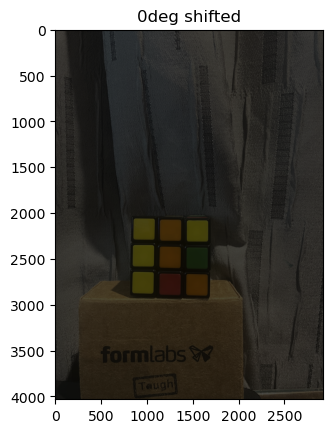

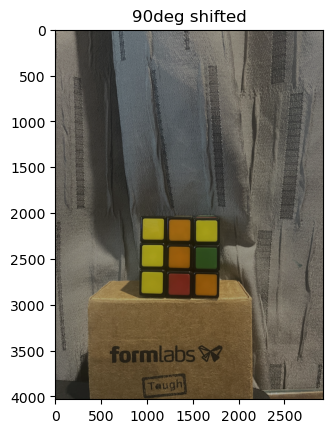

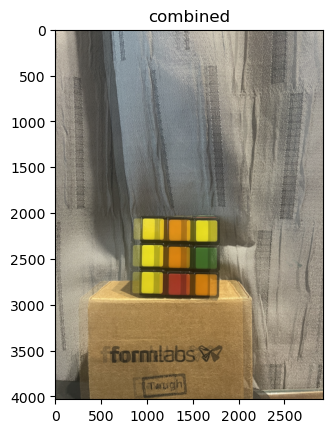

In [115]:
# shift image block_0 left by 100 pixels
block_0_shifted = block_0[:,100:,:]
# shift image block_90 right by 100 pixels
block_90_shifted = block_90[:,:-100,:]

# save block0 and block90
cv2.imwrite('rubix/block_0_shifted.jpg', cv2.cvtColor(block_0_shifted, cv2.COLOR_RGB2BGR))
cv2.imwrite('rubix/block_90_shifted.jpg', cv2.cvtColor(block_90_shifted, cv2.COLOR_RGB2BGR))

#display both
plt.figure()
plt.imshow(block_0_shifted)
plt.title('0deg shifted')
plt.show()

plt.figure()
plt.imshow(block_90_shifted)
plt.title('90deg shifted')
plt.show()

# add both images on top of each other and dispaly
block_combined = block_0_shifted + block_90_shifted
plt.figure()
plt.imshow(block_combined)
plt.title('combined')
plt.show()


limear contrast enhancement to two seperate images?

In [164]:
# linear contrast enhancement function
def linear_contrast_enhancement(im):
    # get min and max pixel values
    a = np.min(im)
    b = np.max(im)
    

    d = 100
    c = 0
    mult = (d - c) / (b - a)

    # apply linear contrast enhancement
    im_enhanced = (im - a) * mult + c

    return im_enhanced

# constrast enhancement accross all rgb values
def linear_contrast_enhancement_rgb(im):
    im_enhanced = np.zeros(im.shape, dtype=np.uint8)
    for i in range(im.shape[2]):
        im_enhanced[:,:,i] = linear_contrast_enhancement(im[:,:,i])
    return im_enhanced

https://stackoverflow.com/questions/24768222/how-to-detect-a-shift-between-images

In [117]:
def cross_image(im1, im2):
   # get rid of the color channels by performing a grayscale transform
   # the type cast into 'float' is to avoid overflows
   im1_gray = np.sum(im1.astype('float'), axis=2)
   im2_gray = np.sum(im2.astype('float'), axis=2)

   # get rid of the averages, otherwise the results are not good
   im1_gray -= np.mean(im1_gray)
   im2_gray -= np.mean(im2_gray)

   # calculate the correlation image; note the flipping of onw of the images
   return scipy.signal.fftconvolve(im1_gray, im2_gray[::-1,::-1], mode='same')

sameim = cross_image(block_0_shifted, block_0_shifted)
shifted = cross_image(block_0_shifted, block_90_shifted)

In [118]:
# take brightest spot of sameim
coord = np.unravel_index(np.argmax(sameim), sameim.shape)
print(coord)
coord_diff = np.unravel_index(np.argmax(shifted), shifted.shape)
print(coord_diff)

# x diff
x_diff = abs(coord_diff[1] - coord[1])
# y diff
y_diff = abs(coord_diff[0] - coord[0])
print(f"x_diff: {x_diff} y_diff: {y_diff}")


(2016, 1462)
(2016, 1362)
x_diff: 100 y_diff: 0


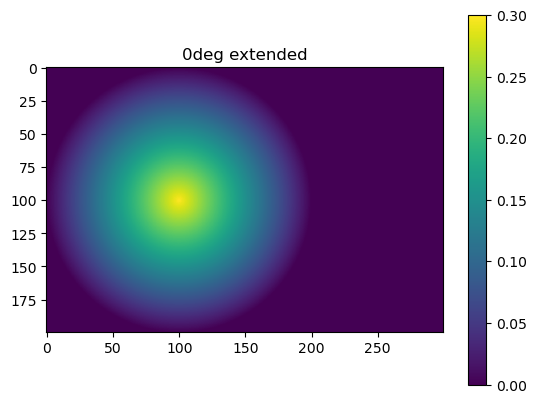

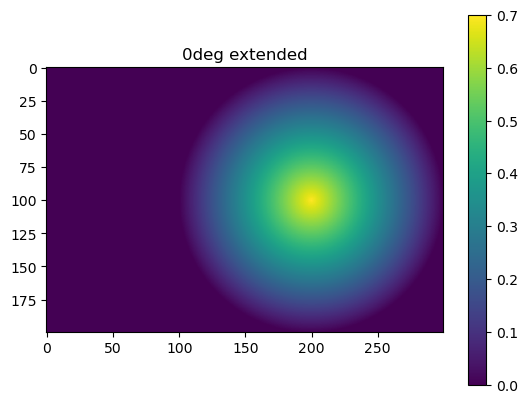

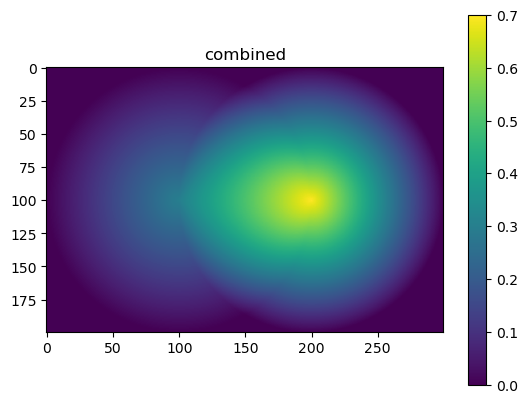

0.7


In [119]:

def create_psf():
    # center point (100,100) should be  extactly equal to 1.0
    # from center point, 100 pixels to the right should go linearly down to 0.0 at (100,200)
    # from center point, 100 pixels to the left should go linearly down to 0.0 at (100,0)
    # up and down are followed by this same rule.
    # all other pixels should follow this however keep to the gradient of the line
    psf = np.zeros((200,200))
    for i in range(200):
        for j in range(200):
            # calculate distance from center
            dist = math.sqrt((i-100)**2 + (j-100)**2)
            # if distance is 0, set to 1
            if dist == 0:
                psf[i,j] = 1
            # if distance is 100, set to 0
            # elif dist == 100:
            #     psf[i,j] = 0
            # if distance is between 0 and 100, set to gradient
            elif dist <= 100:
                # psf[i,j] = 1 - dist/100
                psf[i,j] = 1 - dist/100
    return psf

psf_0deg = 0.3 * create_psf()
psf_90deg = 0.7 * create_psf()

# extend psf0 right and psf90 left so the two can be added. each center point should be 100 pixels away from each other
psf_0deg_extended = np.zeros((200,300))
psf_0deg_extended[:,:200] = psf_0deg
psf_90deg_extended = np.zeros((200,300))
psf_90deg_extended[:,100:] = psf_90deg

plt.figure()
plt.imshow(psf_0deg_extended)
plt.title('0deg extended')
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(psf_90deg_extended)
plt.title('0deg extended')
plt.colorbar()
plt.show()

# add both psfs
psf_combined = psf_0deg_extended + psf_90deg_extended
plt.figure()
plt.imshow(psf_combined)
plt.title('combined')
plt.colorbar()
plt.show()

#get max val of psf_combined
max_psf = np.max(psf_combined)
print(max_psf)

the above would probably be more useful if were doing upward shifting but for the sake of the sim should use even boxes instead


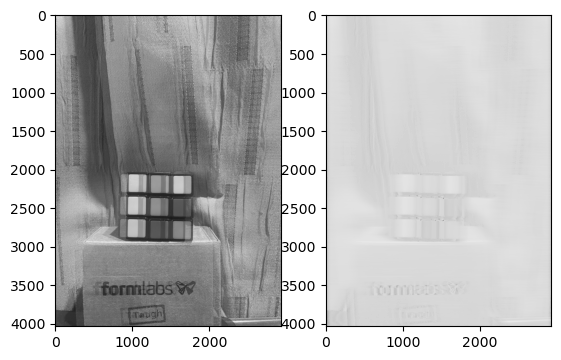

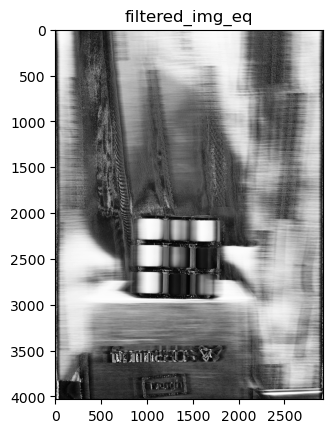

In [170]:
from skimage import color, data, restoration
from scipy.signal import wiener

#greyscale
block_combined_grey = cv2.cvtColor(block_combined, cv2.COLOR_RGB2GRAY)

rng = np.random.default_rng()
filtered_img = wiener(block_combined_grey,(1,125))  #Filter the image
f, (plot1, plot2) = plt.subplots(1, 2)
plot1.imshow(block_combined_grey)
plot2.imshow(filtered_img)
plt.show()

# histogram equalise filteredimg and uint8
filtered_img_eq = cv2.equalizeHist(filtered_img.astype(np.uint8))
plt.figure()
plt.imshow(filtered_img_eq)
plt.title('filtered_img_eq')
plt.show()
